In [1]:
import os
try:
    path_initialized
except NameError:
    path_initialized = True
    os.chdir('..')
from swiper.predictor import simulate_temporal_speculation, process_failures

## Predictor Accuracy

In [17]:
REGENERATE_DATA = False

In [18]:
import pickle as pkl
d_range = [13, 15, 17, 19, 21, 23, 25, 27, 29, 31]
p_range = [1e-3]

if REGENERATE_DATA:
    for i, config in enumerate([[2,3], [3], []]):
        results = {}
        for p in p_range:
            for d in d_range:
                results[(p,d)] = simulate_temporal_speculation(5_000, d, p, ignore_steps=config)
        pkl.dump(results, open(f'notebooks/data/0{i+1}-step-predictor-results.pkl', 'wb'))

        print(f'{i+1}-Step Predictor Done')



In [19]:
if REGENERATE_DATA:
    one_step_data = pkl.load(open('notebooks/data/01-step-predictor-results.pkl', 'rb'))
    two_step_data = pkl.load(open('notebooks/data/02-step-predictor-results.pkl', 'rb'))    
    three_step_data = pkl.load(open('notebooks/data/03-step-predictor-results.pkl', 'rb'))

    for i, results in enumerate([one_step_data, two_step_data, three_step_data]):
        processed_results = {}
        for p in p_range:
            for d in d_range:
                false_neg, false_pos, both = process_failures(results[(p,d)][2], d=d)
                processed_results[(p,d)] = (results[(p,d)][0], results[(p,d)][1], (false_neg, false_pos, both))
        pkl.dump(processed_results, open(f'notebooks/data/processed_0{i+1}-step-predictor-results.pkl', 'wb'))

### Plotting

In [20]:
one_step_data = pkl.load(open('notebooks/data/processed_01-step-predictor-results.pkl', 'rb'))
two_step_data = pkl.load(open('notebooks/data/processed_02-step-predictor-results.pkl', 'rb'))    
three_step_data = pkl.load(open('notebooks/data/processed_03-step-predictor-results.pkl', 'rb'))

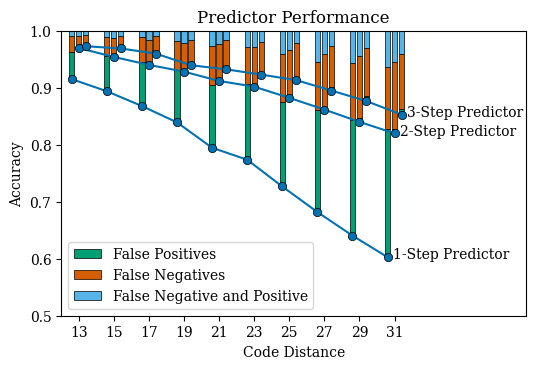

In [21]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
plt.rcParams["font.family"] = "serif"
color_list = ['#0072B2', '#CC79A7', '#009E73', '#E69F00', '#56B4E9', '#D55E00', '#F0E442']
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=color_list)

bs = 0.4 # bar spacing
bw = 0.3 # bar width
plt.figure(figsize=(6, 3.7))
titles = {
    0: 'Naive',
    1: 'Binned',
    2: 'Binned+'
}
for i, results in enumerate([one_step_data, two_step_data, three_step_data]):
    for p in p_range:
        speculation_accuracy = {d: results[(p,d)][1].count(True)/len(results[(p,d)][1]) for d in d_range}
        plt.plot([(d-bs)+bs*i for d in d_range], [speculation_accuracy[d] for d in d_range], marker='o', color=color_list[0], markeredgecolor='black', markeredgewidth=.5)#, label=f'{i+1}-Step Predictor')
        plt.text((31.3 - bs)+bs*i, speculation_accuracy[31] - 0.003, f'{i+1}-Step Predictor', color='black')

        if p == 1e-3:
            for d in d_range:
                lb = speculation_accuracy[d]
                false_neg, false_pos, both = results[(p,d)][2]
                num_failures = results[(p,d)][1].count(False)
                pos_h = (1 - lb) * (false_pos / num_failures)
                plt.bar(x=(d-bs)+bs*i, width=bw, height=pos_h, bottom=lb, color=color_list[2], label='False Positives' if d == 13 and i == 0 else None, edgecolor='black', linewidth=.5)
                false_h = (1 - lb) * (false_neg / num_failures)
                plt.bar(x=(d-bs)+bs*i, width=bw, height=false_h, bottom=lb+pos_h, color=color_list[5], label='False Negatives' if d == 13 and i == 0 else None, edgecolor='black', linewidth=.5)
                plt.bar(x=(d-bs)+bs*i, width=bw, height=(1 - lb) * both / num_failures, bottom=lb+false_h+pos_h, color=color_list[4], label='False Negative and Positive' if d == 13 and i == 0 else None, edgecolor='black', linewidth=.5)

plt.xlim(12, 38.5)
plt.ylim(0.5, 1)
plt.legend(loc='lower left')
plt.xticks(d_range)
plt.ylabel('Accuracy')
plt.xlabel('Code Distance')
plt.title(f'Predictor Performance')
plt.savefig('notebooks/figures/predictor_accuracy.pdf', bbox_inches='tight')


## Speculation Strategy

In [5]:
from swiper.predictor import strategy_sim
import networkx as nx
import numpy as np

In [6]:
d=13
num_nodes = 100
num_shots = 10_000
decode_times = [2 * 13, 5 * 13, 10 * 13]
test_graph = nx.DiGraph()
test_graph.add_nodes_from([(node, {'t': d * node}) for node in range(num_nodes)])
test_graph.add_edges_from([(i, i+1) for i in range(num_nodes - 1)])
adj_pairs = list(zip(list(test_graph.edges())[:-1], list(test_graph.edges())[1:]))
opt_runtimes = {decode_time: [] for decode_time in decode_times}
opt_classicals = {decode_time: [] for decode_time in decode_times}
opt_procs = {decode_time: [] for decode_time in decode_times}
pes_runtimes = {decode_time: [] for decode_time in decode_times}
pes_classicals = {decode_time: [] for decode_time in decode_times}
pes_procs = {decode_time: [] for decode_time in decode_times}
adj_runtimes = {decode_time: [] for decode_time in decode_times}
adj_classicals = {decode_time: [] for decode_time in decode_times}
adj_procs = {decode_time: [] for decode_time in decode_times}

for decode_time in decode_times:
    for _ in range(num_shots):
        opt_runtime, opt_classical, opt_valid, opt_proc = strategy_sim(test_graph, adj_pairs, decode_time, 1, 0.9, 0.95, 'optimistic')
        assert opt_valid == num_nodes * decode_time
        pes_runtime, pes_classical, pes_valid, pes_proc = strategy_sim(test_graph, adj_pairs, decode_time, 1, 0.9, 0.95, 'pessimistic')
        assert pes_valid == num_nodes * decode_time
        adj_runtime, adj_classical, adj_valid, adj_proc = strategy_sim(test_graph, adj_pairs, decode_time, 1, 0.9, 0.95, 'adjacent')
        assert adj_valid == num_nodes * decode_time
        opt_runtimes[decode_time].append(opt_runtime)
        opt_classicals[decode_time].append(opt_classical)
        opt_procs[decode_time].append(opt_proc)
        pes_runtimes[decode_time].append(pes_runtime)
        pes_classicals[decode_time].append(pes_classical)
        pes_procs[decode_time].append(pes_proc)
        adj_runtimes[decode_time].append(adj_runtime)
        adj_classicals[decode_time].append(adj_classical)
        adj_procs[decode_time].append(adj_proc)

### Plotting

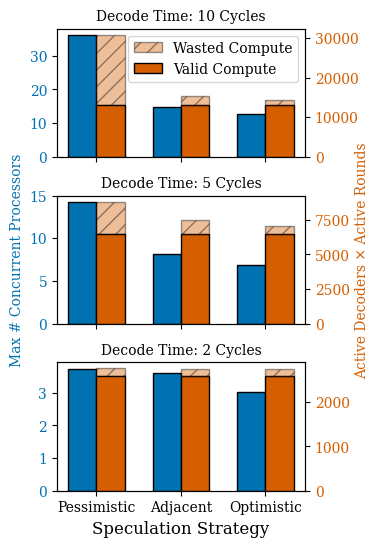

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(3.2, 6))
plt.subplots_adjust(hspace=0.3)

for i, decode_time in enumerate(decode_times[::-1]):
    ax1 = axes[i]
    ax2 = ax1.twinx()
    real = decode_time * num_nodes

    ax1.bar(0.5, np.mean(pes_procs[decode_time]), color=color_list[0], width=0.2, edgecolor='black')
    ax2.bar(0.7, np.mean(pes_classicals[decode_time]) - real, bottom=real, color=color_list[5], 
        edgecolor='black', width=0.2, hatch='//', alpha=0.4, label='Wasted Compute' if i == 0 else None)
    ax2.bar(0.7, real, color=color_list[5], width=0.2, edgecolor='black', label='Valid Compute' if i == 0 else None)

    ax1.bar(1.1, np.mean(adj_procs[decode_time]), color=color_list[0], width=0.2, edgecolor='black')
    ax2.bar(1.3, real, color=color_list[5], width=0.2, edgecolor='black')
    ax2.bar(1.3, np.mean(adj_classicals[decode_time]) - real, bottom=real, color=color_list[5], edgecolor='black', width=0.2, hatch='//', alpha=0.4)

    ax1.bar(1.7, np.mean(opt_procs[decode_time]), color=color_list[0], width=0.2, edgecolor='black')
    ax2.bar(1.9, real, color=color_list[5], width=0.2, edgecolor='black')
    ax2.bar(1.9, np.mean(opt_classicals[decode_time]) - real, bottom=real, color=color_list[5], edgecolor='black', width=0.2, hatch='//', alpha=0.4)

    ax1.tick_params(axis='y', labelcolor=color_list[0])
    ax2.tick_params(axis='y', labelcolor=color_list[5])

    ax1.set_xticks([0.6, 1.2, 1.8])
    if i == 2:
        ax1.set_xticklabels(['Pessimistic', 'Adjacent', 'Optimistic'])
        ax1.set_xlabel('Speculation Strategy', fontsize=12)
    else:
        ax1.set_xticklabels([])

    if i == 0:
        ax2.legend()

    if i == 1:
        ax1.set_ylabel('Max # Concurrent Processors', color=color_list[0])
        ax2.set_ylabel('Active Decoders × Active Rounds', color=color_list[5])
    
    ax1.set_title(f'Decode Time: {decode_time // 13} Cycles', fontsize=10)

plt.savefig('notebooks/figures/speculation_strategy.pdf', bbox_inches='tight')
plt.show()
